In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import smc
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
## dataset parameters
T = 50 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 10 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [4]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [5]:
trajectory = torch.Tensor(STATEs[0])
displacements = torch.Tensor(Disps[0])

data = {}

for i, point in enumerate(trajectory):
    data['position_%d' % i] = torch.Tensor(point[:2])
    if i >= 1:
        data['displacement_%d' % i] = displacements[i-1]

In [6]:
num_particles = 500

In [7]:
bouncing_ball_step = combinators.Model(bouncing_ball.bouncing_ball_step, {}, {
    'delta_t': torch.ones(1),
})

In [8]:
init_bouncing_ball = combinators.Model(bouncing_ball.init_bouncing_ball, {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'loc': {
            'loc': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * (1/np.sqrt(2)),
            'scale': torch.ones(4, 2) * 0.1,
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}, {})

In [9]:
smc_runner = smc.SequentialMonteCarlo(bouncing_ball_step, len(trajectory) - 1)

In [10]:
inference, init_bouncing_ball_params = smc.variational_smc(num_particles, init_bouncing_ball, smc_runner, 100, data,
                                                           use_cuda=False, lr=1e-2)

07/31/2018 14:26:06 Variational SMC ELBO=-1.04594336e+03 at epoch 1
07/31/2018 14:26:13 Variational SMC ELBO=-1.10551453e+03 at epoch 2
07/31/2018 14:26:18 Variational SMC ELBO=-1.10248022e+03 at epoch 3
07/31/2018 14:26:24 Variational SMC ELBO=-1.10345325e+03 at epoch 4
07/31/2018 14:26:30 Variational SMC ELBO=-1.03865149e+03 at epoch 5
07/31/2018 14:26:37 Variational SMC ELBO=-1.11374341e+03 at epoch 6
07/31/2018 14:26:43 Variational SMC ELBO=-1.09836328e+03 at epoch 7
07/31/2018 14:26:50 Variational SMC ELBO=-1.09282996e+03 at epoch 8
07/31/2018 14:26:58 Variational SMC ELBO=-1.22848926e+03 at epoch 9
07/31/2018 14:27:05 Variational SMC ELBO=-1.15840063e+03 at epoch 10
07/31/2018 14:27:11 Variational SMC ELBO=-1.14990442e+03 at epoch 11
07/31/2018 14:27:17 Variational SMC ELBO=-1.08412756e+03 at epoch 12
07/31/2018 14:27:24 Variational SMC ELBO=-1.14907507e+03 at epoch 13
07/31/2018 14:27:31 Variational SMC ELBO=-1.01281256e+03 at epoch 14
07/31/2018 14:27:37 Variational SMC ELBO=-1

In [11]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles, len(trajectory), 2)
    result[:, 0] = inference['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['displacement_%d' % (t+1)].value
    return result

inferred_trajectory = accumulate_trajectory(inference)

In [13]:
T = len(trajectory) - 1

In [14]:
positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [15]:
displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [16]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

In [17]:
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)

In [18]:
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)

In [19]:
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

In [20]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

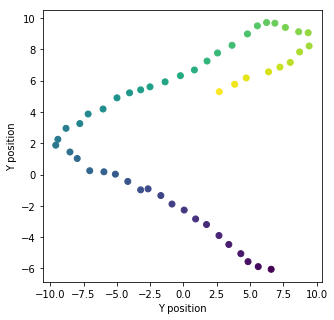

In [21]:
gs = gridspec.GridSpec(2, 2)
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.gca()

ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
ax1.set_xlim([-Boundary, Boundary])
ax1.set_ylim([-Boundary, Boundary])
#ax1.set_xticks([])
#ax1.set_yticks([])
ax1.set_ylabel('Y position')
ax1.set_xlabel('Y position')
plt.savefig('position_over_time.pdf')

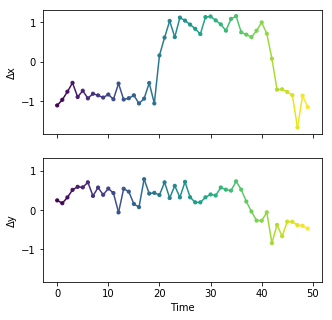

In [22]:
fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
dx_lc.set_array(np.arange(T - 1))
ax2.add_collection(dx_lc)
ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
#ax2.set_xlabel('t')
ax2.set_ylabel('Δx')

dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
dy_lc.set_array(np.arange(T-1))
ax3.add_collection(dy_lc)
ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
ax3.set_xlabel('Time')
ax3.set_ylabel('Δy')

plt.savefig('time_vs_delta_xys.pdf')

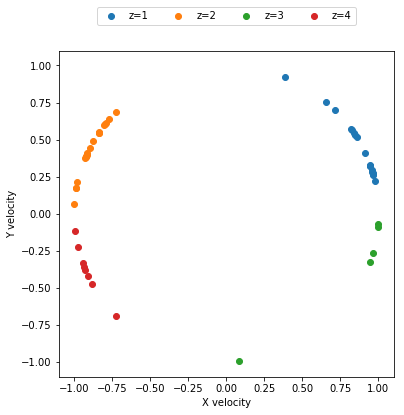

In [23]:
directions = displacements / displacements.norm(dim=-1).unsqueeze(-1)
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
z1_directions = torch.masked_select(directions, ((directions[:, 0] > 0) * (directions[:, 1] > 0)).unsqueeze(-1)).reshape(-1, 2)
z2_directions = torch.masked_select(directions, ((directions[:, 0] < 0) * (directions[:, 1] > 0)).unsqueeze(-1)).reshape(-1, 2)
z3_directions = torch.masked_select(directions, ((directions[:, 0] > 0) * (directions[:, 1] < 0)).unsqueeze(-1)).reshape(-1, 2)
z4_directions = torch.masked_select(directions, ((directions[:, 0] < 0) * (directions[:, 1] < 0)).unsqueeze(-1)).reshape(-1, 2)
if z1_directions.shape[0] > 0:
    ax.scatter(z1_directions[:, 0], z1_directions[:, 1], label='z=1')
if z2_directions.shape[0] > 0:
    ax.scatter(z2_directions[:, 0], z2_directions[:, 1], label='z=2')
if z3_directions.shape[0] > 0:
    ax.scatter(z3_directions[:, 0], z3_directions[:, 1], label='z=3')
if z4_directions.shape[0] > 0:
    ax.scatter(z4_directions[:, 0], z4_directions[:, 1], label='z=4')
ax.set_xlabel('X velocity')
ax.set_ylabel('Y velocity')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.savefig('velocity_frequencies.pdf')

In [24]:
positions = torch.stack([data['position_%d' % (t+1)] for t in range(T)], dim=0).cpu().detach()

In [25]:
displacements = torch.stack([data['displacement_%d' % (t+1)] for t in range(T)], dim=0).cpu().detach()

In [26]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

In [27]:
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(-1).to(displacements), displacements[:-1]), dim=-1)

In [28]:
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(-1).to(displacements) + 1, displacements[1:]), dim=-1)

In [29]:
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

In [30]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

Text(0.5,0,'Y position')

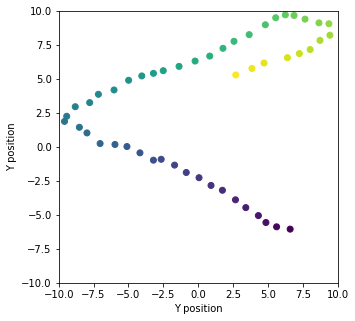

In [31]:
gs = gridspec.GridSpec(2, 2)
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.gca()

ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
ax1.set_xlim([-Boundary, Boundary])
ax1.set_ylim([-Boundary, Boundary])
#ax1.set_xticks([])
#ax1.set_yticks([])
ax1.set_ylabel('Y position')
ax1.set_xlabel('Y position')

Text(0,0.5,'Δy')

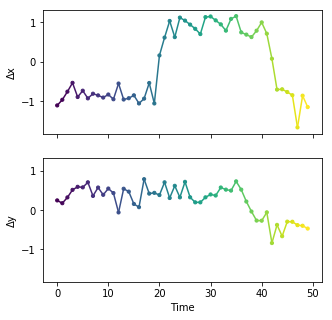

In [32]:
fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
dx_lc.set_array(np.arange(T - 1))
ax2.add_collection(dx_lc)
ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
#ax2.set_xlabel('t')
ax2.set_ylabel('Δx')

dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
dy_lc.set_array(np.arange(T-1))
ax3.add_collection(dy_lc)
ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
ax3.set_xlabel('Time')
ax3.set_ylabel('Δy')